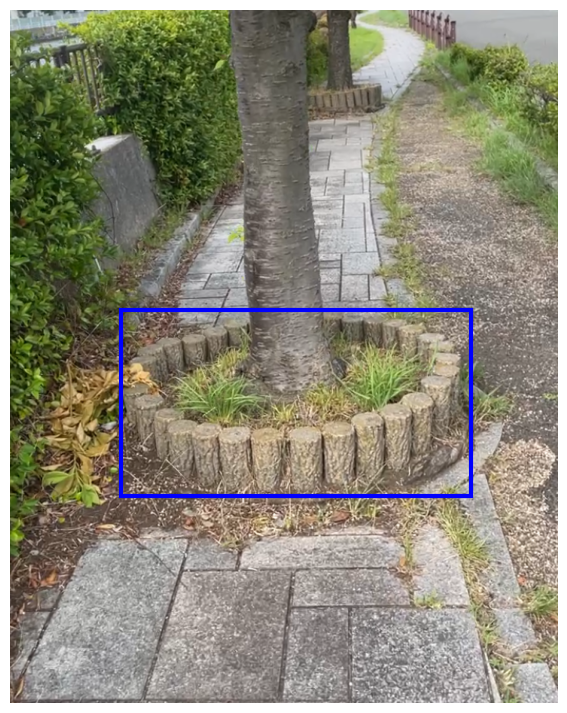

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

import warnings
warnings.filterwarnings('ignore')


# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "IDEA-Research/grounding-dino-base"
# Load the pretrained DETR model and processor
zeroshot_processor = AutoProcessor.from_pretrained(model_id)
zeroshot_model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

# Load an image from URL or local path
image_url = "tree root lifting the pavement.png"
caption = "tree root lifting the pavement, creating uneven surface and potential tripping hazard"
#image_url = f"{caption}.png"
#image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#image = Image.open(requests.get(image_url, stream=True).raw)
image = Image.open(image_url).convert("RGB")

# Preprocess the image
inputs = zeroshot_processor(images=image, text=caption, return_tensors="pt").to(device)

# Forward pass
with torch.no_grad():
    outputs = zeroshot_model(**inputs)

scores = outputs.logits.softmax(-1)[..., :-1].max(-1).values
threshold = scores.quantile(0.5)  # Keep top 80% confident predictions

# Post-process the results (keep only high-confidence predictions)
target_sizes = torch.tensor([image.size[::-1]])  # (height, width)
results = zeroshot_processor.post_process_grounded_object_detection(outputs, target_sizes=target_sizes, box_threshold=0.3, text_threshold=0.3)[0]

# Draw results
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    xmin, ymin, xmax, ymax = box.cpu().numpy()
    ax.add_patch(patches.Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin,
        fill=False, edgecolor='Blue', linewidth=3
    ))
    caption = f"{label}: {score:.2f}"
    #ax.text(xmin, ymin, caption, fontsize=12, color='white',bbox=dict(facecolor='red', alpha=0.5))

plt.axis("off")
plt.show()
